In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
sns.set_theme(style="whitegrid")

In [3]:
FILE_PATH = 'data/blink/aida_dev.jsonl'

In [4]:
df = pd.read_json(FILE_PATH, lines=True)

Basic Dataset Stats

In [5]:
num_mentions = len(df)

In [6]:
num_docs = df['query_id'].nunique() 
num_unique_entities = df['Wikipedia_title'].nunique()

In [7]:
print(f"Total Mentions: {num_mentions}")
print(f"Total Unique Documents (based on 'query_id'): {num_docs}")
print(f"Total Unique Entities (linked): {num_unique_entities}")

Total Mentions: 4791
Total Unique Documents (based on 'query_id'): 4791
Total Unique Entities (linked): 1644


### Ambiguity Analysis

1. Mention Length Distribution

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


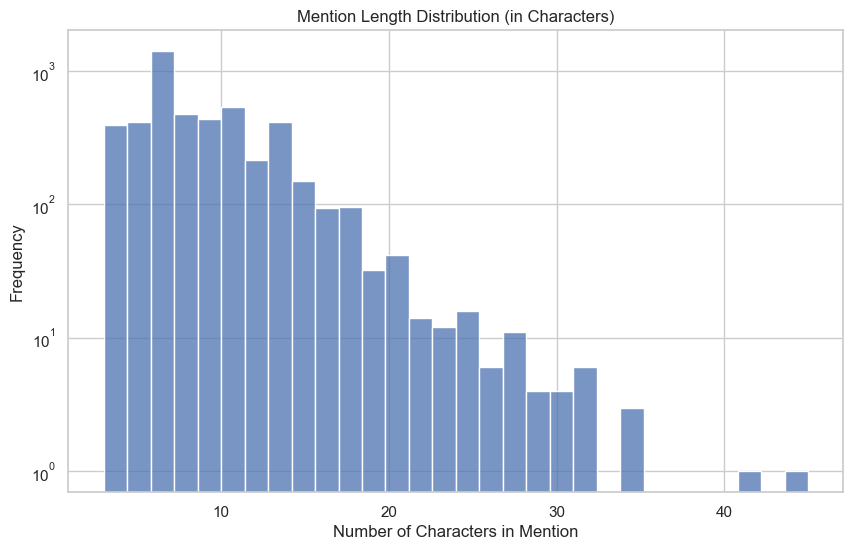

In [8]:
df['mention_length'] = df['mention'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(df['mention_length'], bins=30, kde=False)
plt.title('Mention Length Distribution (in Characters)')
plt.xlabel('Number of Characters in Mention')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show() 

2. Mention Frequency

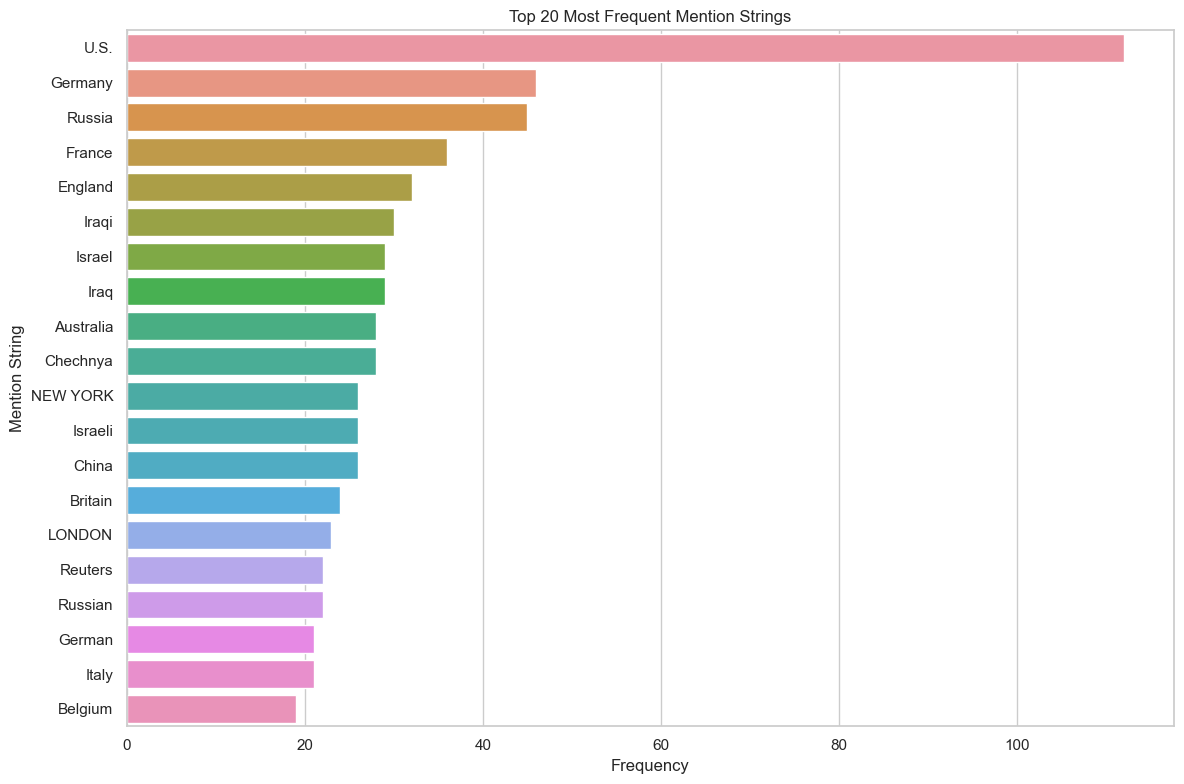

In [9]:
plt.figure(figsize=(12, 8))
top_20_mentions = df['mention'].value_counts().head(20)
sns.barplot(x=top_20_mentions.values, y=top_20_mentions.index, orient='h')
plt.title('Top 20 Most Frequent Mention Strings')
plt.xlabel('Frequency')
plt.ylabel('Mention String')
plt.tight_layout()
plt.show()

3. Polysemy Analysis (The "Money" Slide)

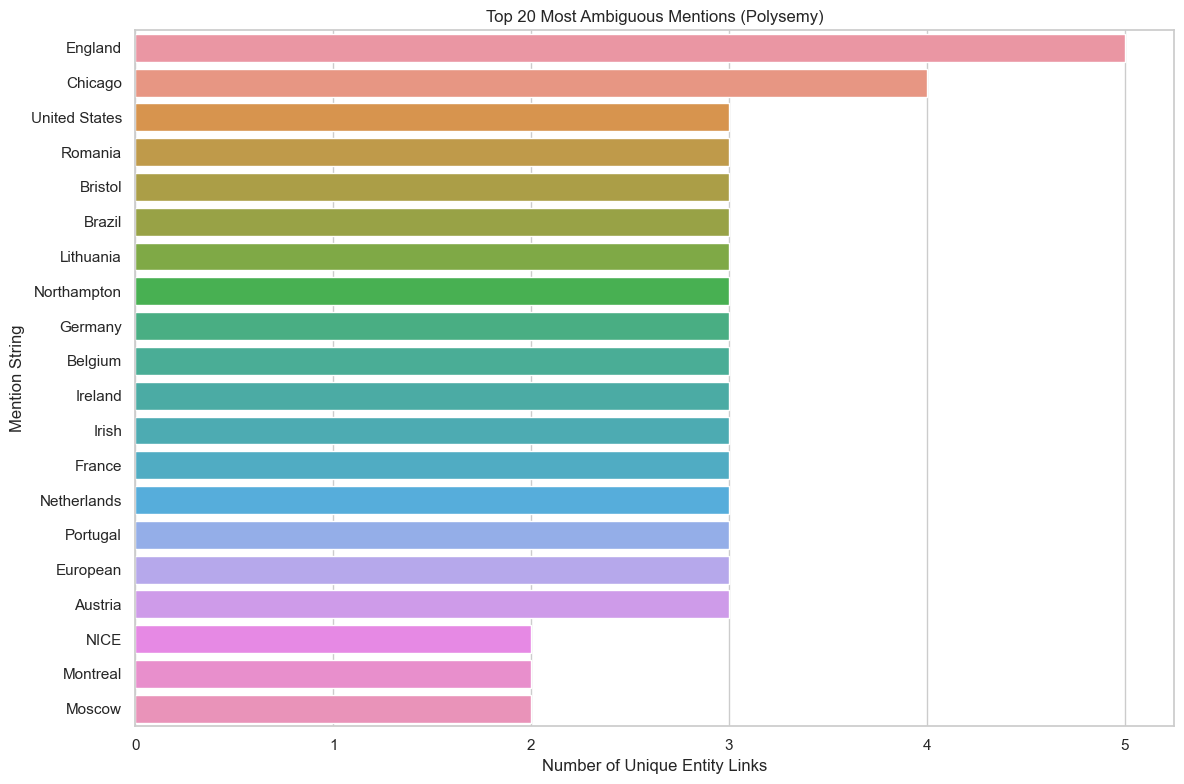

In [10]:
polysemy_df = df.groupby('mention')['Wikipedia_title'].nunique().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
top_20_ambiguous = polysemy_df.head(20)
sns.barplot(x=top_20_ambiguous.values, y=top_20_ambiguous.index, orient='h')
plt.title('Top 20 Most Ambiguous Mentions (Polysemy)')
plt.xlabel('Number of Unique Entity Links')
plt.ylabel('Mention String')
plt.tight_layout()
plt.show() 

4. Average Ambiguity by Mention Length

In [11]:
polysemy_map = df.groupby('mention')['Wikipedia_title'].nunique()
df['ambiguity_score'] = df['mention'].map(polysemy_map)
df['is_ambiguous'] = df['ambiguity_score'] > 1

df['mention_length'] = df['mention'].str.len()

df['full_context'] = df['context_left'] + " " + df['mention'] + " " + df['context_right']
df['context_length'] = df['full_context'].str.split().str.len()

def get_mention_shape(mention):
    mention_str = str(mention)
    if mention_str.isupper() and len(mention_str) <= 5:
        return 'Abbreviation (ALL CAPS)'
    elif ' ' in mention_str:
        return 'Multi-Word'
    elif mention_str.istitle():
        return 'Single Word (Title Case)'
    else:
        return 'Other (e.g., lowercase)'
        
df['mention_shape'] = df['mention'].apply(get_mention_shape)


C:\Users\pc\AppData\Local\Temp\ipykernel_54596\764382603.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_ambiguity_by_length = df.groupby('length_bin')['ambiguity_score'].mean().reset_index()
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


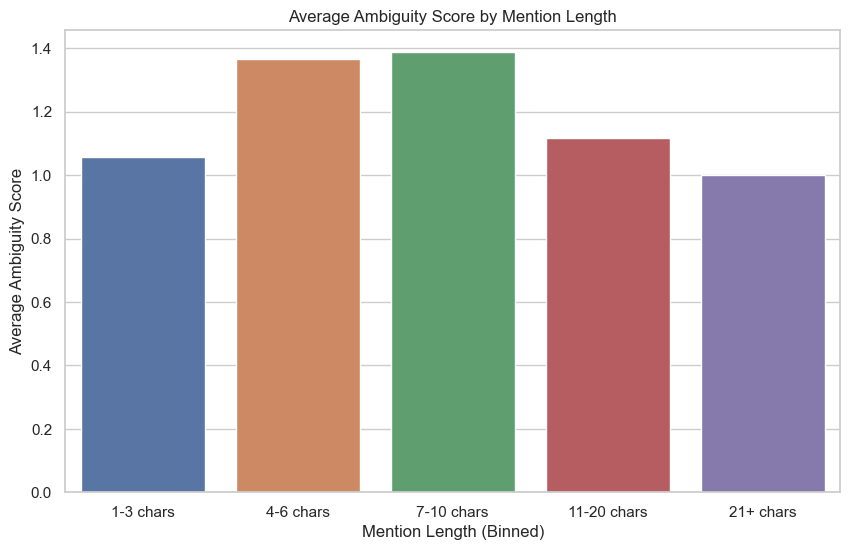

In [12]:
bins = [0, 3, 6, 10, 20, 100]
labels = ['1-3 chars', '4-6 chars', '7-10 chars', '11-20 chars', '21+ chars']
df['length_bin'] = pd.cut(df['mention_length'], bins=bins, labels=labels, right=True)


avg_ambiguity_by_length = df.groupby('length_bin')['ambiguity_score'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_ambiguity_by_length, x='length_bin', y='ambiguity_score')
plt.title('Average Ambiguity Score by Mention Length')
plt.xlabel('Mention Length (Binned)')
plt.ylabel('Average Ambiguity Score')
plt.show()

5. Source of Ambiguous Mentions by Shape

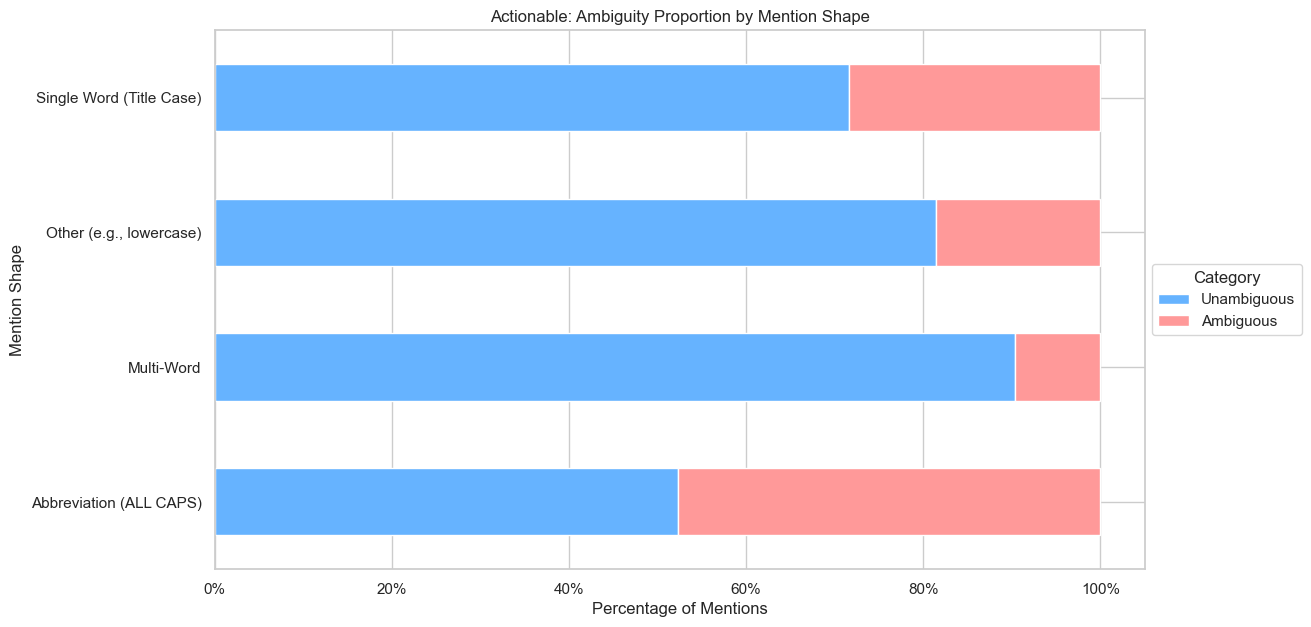

In [13]:
shape_ambiguity_counts = df.groupby('mention_shape')['is_ambiguous'].value_counts().unstack(fill_value=0)
shape_ambiguity_counts.columns = ['Unambiguous', 'Ambiguous']

shape_ambiguity_pct = shape_ambiguity_counts.apply(lambda x: x / x.sum(), axis=1)

shape_ambiguity_pct.plot(
    kind='barh', 
    stacked=True, 
    figsize=(12, 7),
    color=['#66b3ff', '#ff9999']
)
plt.title('Actionable: Ambiguity Proportion by Mention Shape')
plt.xlabel('Percentage of Mentions')
plt.ylabel('Mention Shape')
plt.legend(title='Category', loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.show()


### Context Analysis

1. Context Length Distribution 

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


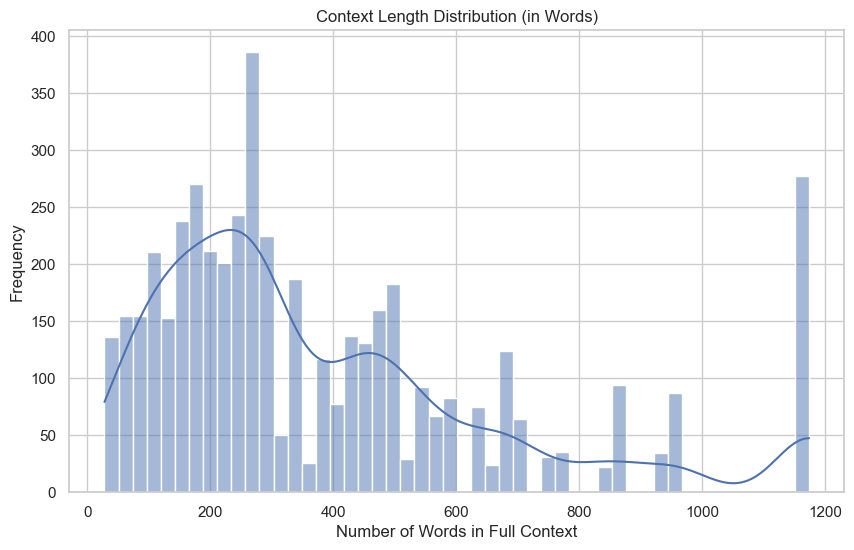

In [14]:
df['full_context'] = df['context_left'] + " " + df['mention'] + " " + df['context_right']

df['context_length'] = df['full_context'].str.split().str.len()

plt.figure(figsize=(10, 6))
sns.histplot(df['context_length'], bins=50, kde=True)
plt.title('Context Length Distribution (in Words)')
plt.xlabel('Number of Words in Full Context')
plt.ylabel('Frequency')
plt.show()

2. Mention Length vs. Context Length

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


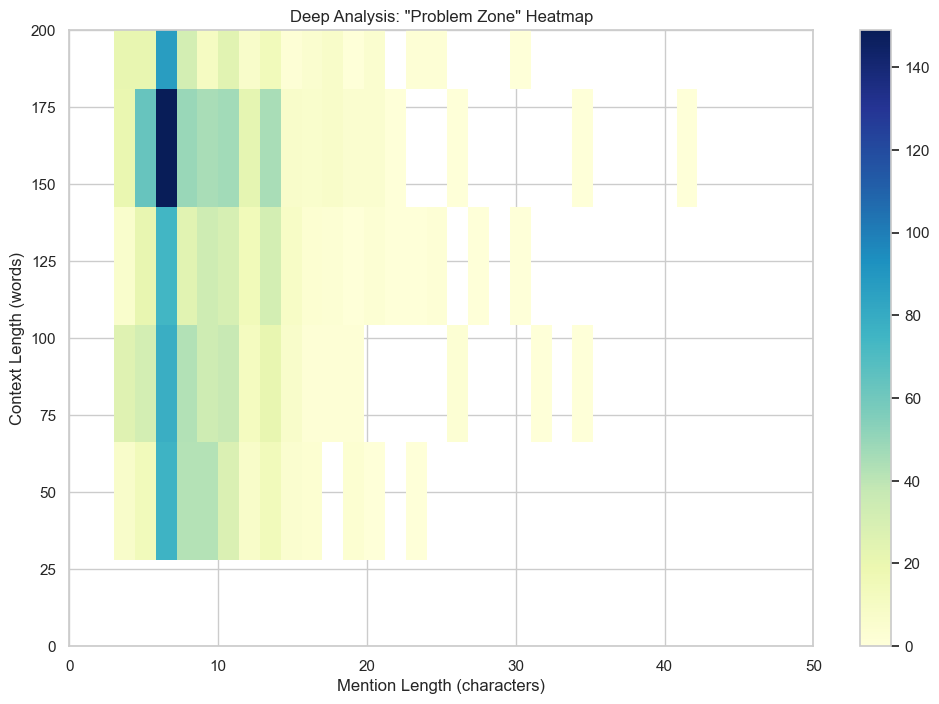

In [15]:
plt.figure(figsize=(12, 8))

sns.histplot(
    data=df,
    x='mention_length',
    y='context_length',
    bins=(30, 30),  
    cbar=True,      
    cmap="YlGnBu"    
)
plt.title('Deep Analysis: "Problem Zone" Heatmap')
plt.xlabel('Mention Length (characters)')
plt.ylabel('Context Length (words)')
plt.xlim(0, 50) 
plt.ylim(0, 200)
plt.show()